In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
%time
import pandas as pd
import numpy as np
import ants
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 6.44 µs


In [3]:
df = pd.read_csv('../Data/ABIDE_df.csv')

In [4]:
rnames = pd.read_csv('../Data/YeoAtlas/roinames.txt',header=None)
rnames = rnames.values
rnames = [rname[0].replace("''",'') for rname in rnames]

In [5]:
rois = ants.image_read('../Data/YeoAtlas/epi_rois.nii.gz')

In [6]:
fntemp = '/mmfs1/data/aglinska/data/ABIDE/Derivatives/cpac_nofilt_global/{sub}/ses-1/func/{sub}_ses-1_YeoCorr.nii.gz'
fn_mask = '/mmfs1/data/aglinska/data/ABIDE/Derivatives/cpac_nofilt_global/{sub}/ses-1/func/{sub}_ses-1_mask.nii.gz'

In [7]:
ch = np.array([os.path.exists(fntemp.format(sub=sub)) for sub in df['bids_folder'].values])
print(ch.sum())

1068


In [8]:
df2 = df.iloc[ch]
#df2 = df2.iloc[0:250]
df2.to_csv('../Data/ABIDE_df2.csv')

In [9]:
sub = df['bids_folder'].values[0]
im = ants.image_read(fntemp.format(sub=sub))
mask = ants.image_read(fn_mask.format(sub=sub))

In [10]:
# LOAD ALL THE IMAGES
ims = [ants.image_read(fntemp.format(sub=sub)) for sub in tqdm(df2['bids_folder'].values)]

100%|██████████| 1068/1068 [04:13<00:00,  4.21it/s]


In [11]:
# SAVE ALL THE IMAGES
#[ims[s].to_filename(os.path.join('../Assets/fc_maps_orig/',df2['bids_folder'].values[s]+'.nii')) for s in tqdm(range(len(df2)))];

In [12]:
# RESAMPLE IMAGES TO 32x32x32x51
#k = 48
#ims = [im.resample_image((k,k,k,51),use_voxels=True,interp_type=4) for im in tqdm(ims)]

In [13]:
# SAVE ALL THE IMAGES
#[ims[s].to_filename(os.path.join('../Assets/fc_maps_48/',df2['bids_folder'].values[s]+'.nii')) for s in tqdm(range(len(df2)))];

In [21]:
#from tqdm.notebook import tqdm
#from tqdm import tqdm

In [22]:
#ims = [ants.image_read(os.path.join('../Assets/fc_maps_48',sub+'.nii')) for sub in tqdm(df2['bids_folder'].values,position=0, leave=True)]

100%|██████████| 1068/1068 [01:00<00:00, 17.74it/s]


In [25]:
# Massive hack to bypass RAM bottleneck
n = len(ims)
im = ims[0]
im_avg = ims[0].numpy()
for i in tqdm(range(1,n),position=0, leave=True):
    #im_avg = np.array([im_avg,ims[i].numpy()]).sum(axis=0)
    im_avg = np.nansum(np.array([im_avg,ims[i].numpy()]),axis=0)
im_avg = im_avg/n
#im_avg = im.new_image_like(im_avg)
im_avg = im.new_image_like(im_avg)

100%|██████████| 1067/1067 [01:08<00:00, 15.47it/s]


In [26]:
im_avg.to_filename('../Misc/im_avg_48.nii')

In [27]:
ims_arr = np.array([im.numpy() for im in tqdm(ims,position=0, leave=True)])

100%|██████████| 1068/1068 [00:07<00:00, 138.73it/s]


In [28]:
ims_arr.shape

(1068, 48, 48, 48, 51)

In [ ]:
# %%time
# np.savez_compressed('../Data/fc_data_4D_1068', data=ims_arr)
# ## 12GBS

In [29]:
subs = df2['bids_folder'].values

In [31]:
for i in tqdm(range(len(subs)),position=0, leave=True):
    np.savez_compressed(f'../Assets/fc_mats/{subs[i]}', data=ims_arr[i,:,:,:,:])

100%|██████████| 1068/1068 [15:04<00:00,  1.18it/s]


In [ ]:
# rr = range(51)
# rr = np.argsort(im_avg.numpy().mean(axis=0).mean(axis=0).mean(axis=0))
# for r in rr:
#     implot = ants.slice_image(im_avg,axis=3,idx=r)
#     implot[np.isnan(implot.numpy())]=0
#     implot.plot_ortho(flat=True,cmap='hot',xyz_lines=False,orient_labels=False,title=rnames[r])

In [32]:
import scipy

In [33]:
map_c = np.corrcoef(np.array([im_avg.numpy()[:,:,:,r].flatten() for r in range(51)]))
Z = scipy.cluster.hierarchy.linkage(1-map_c,method='ward')

<ipython-input-33-48a48d192b05>:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



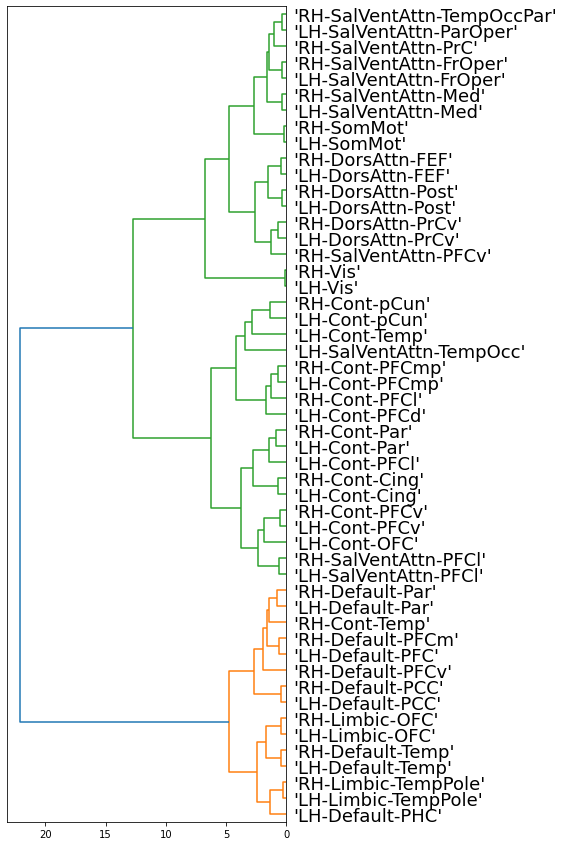

In [34]:
plt.figure(figsize=(5,15));
R = scipy.cluster.hierarchy.dendrogram(Z,p=100,orientation='left',labels=rnames);
ax = plt.gca();
plt.yticks(fontsize=18);

In [35]:
R.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

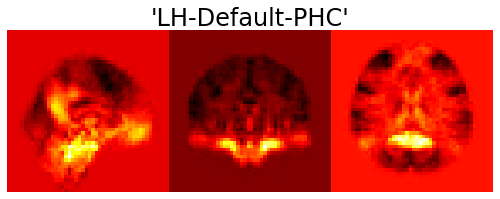

  6%|▋         | 68/1068 [21:52<5:21:43, 19.30s/it]


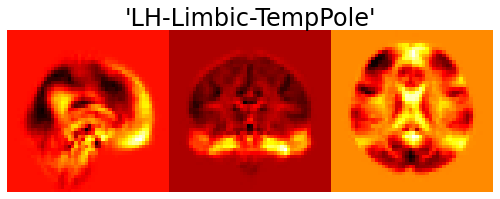

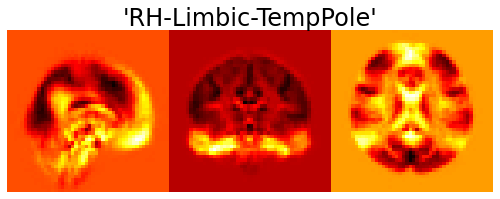

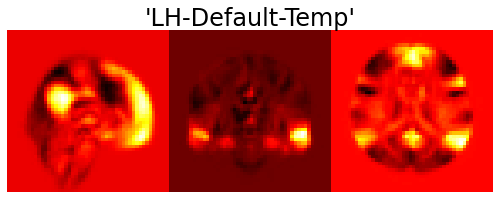

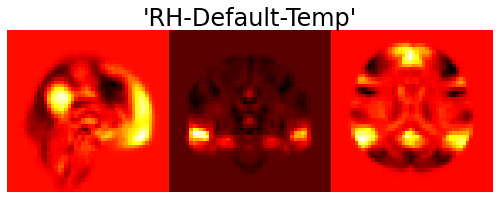

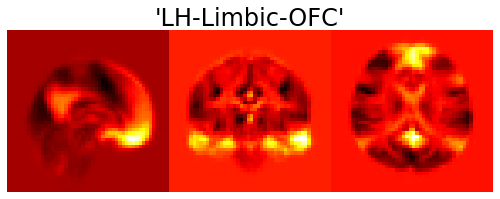

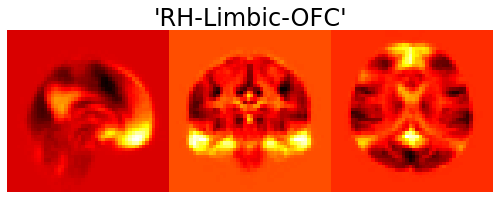

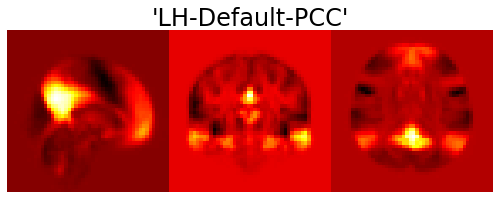

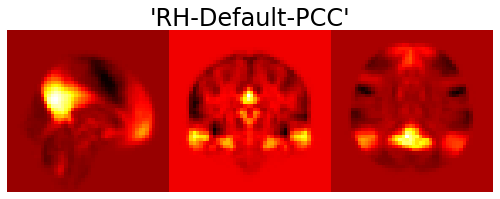

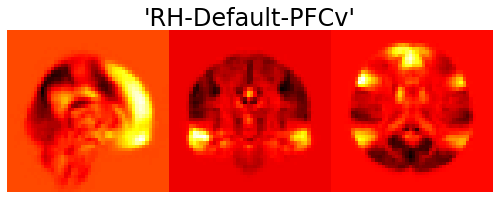

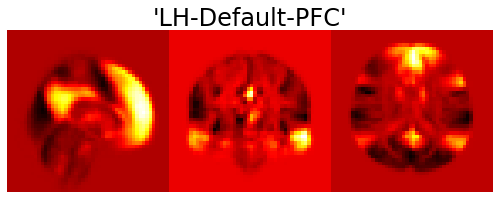

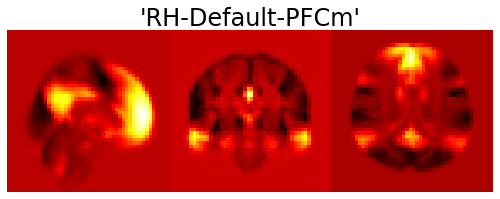

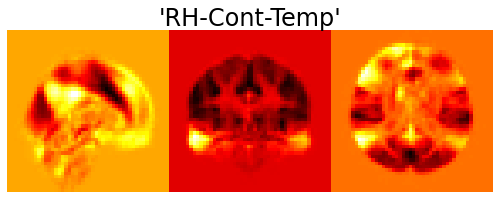

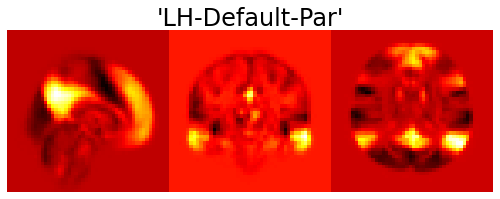

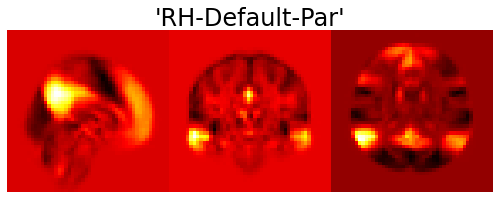

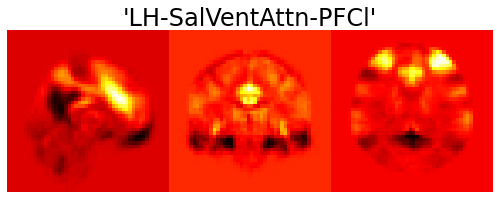

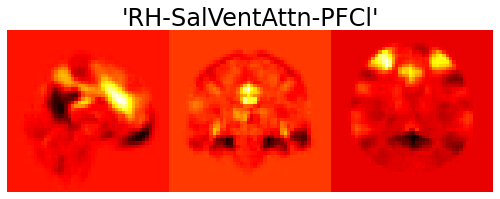

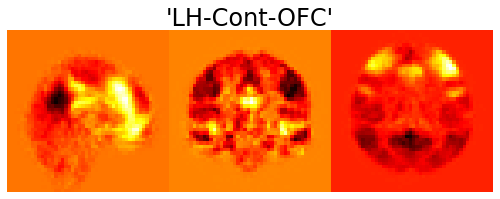

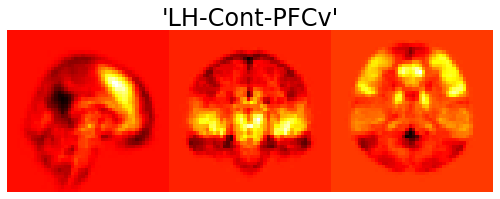

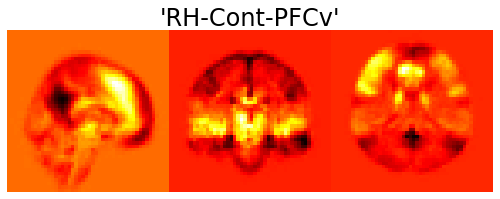

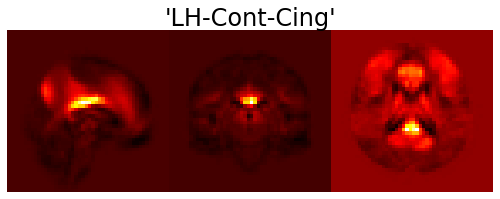

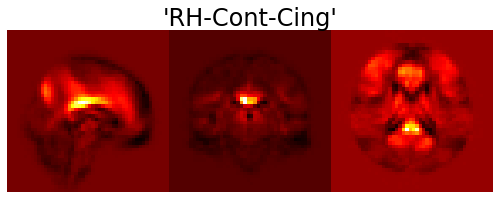

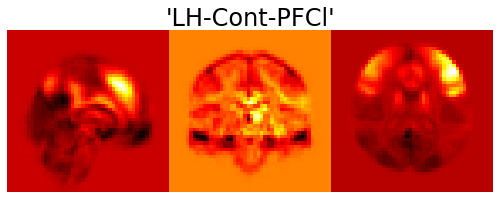

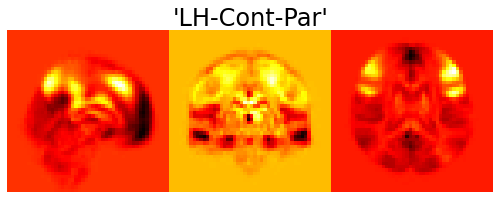

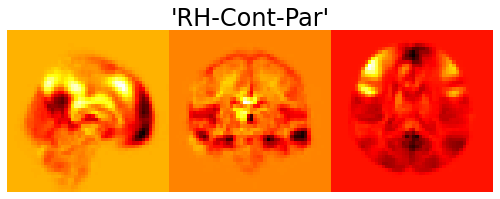

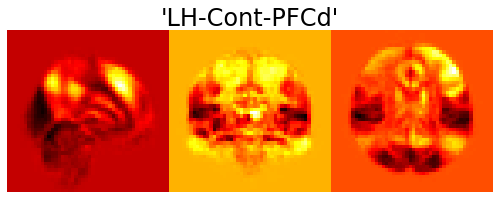

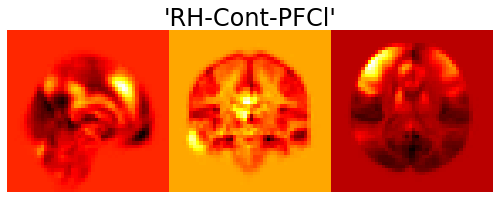

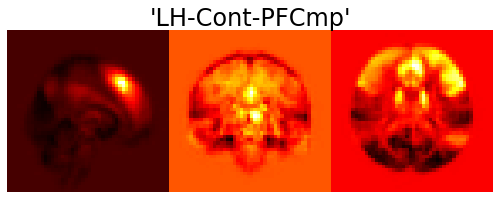

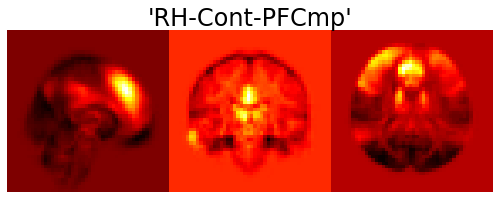

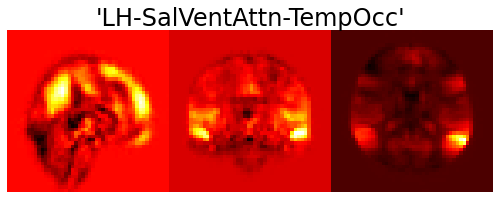

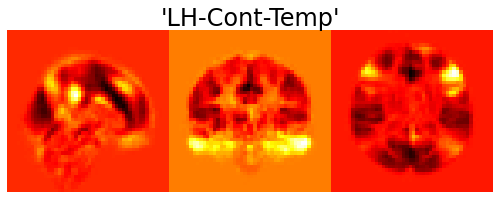

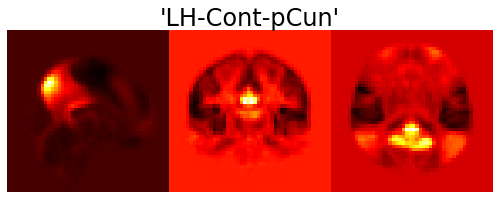

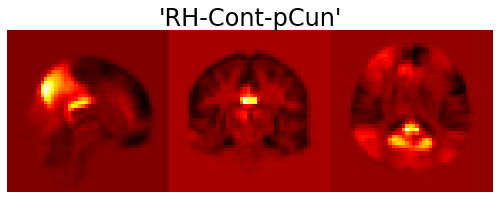

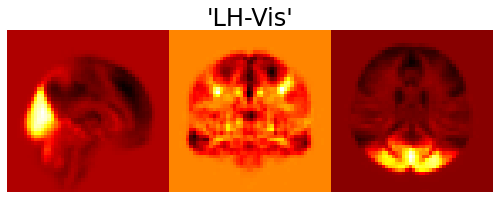

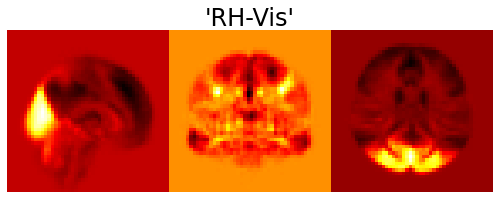

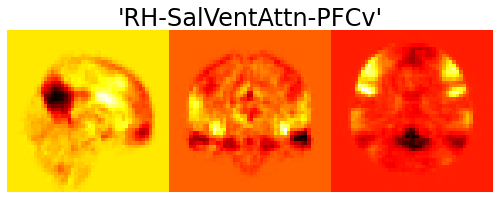

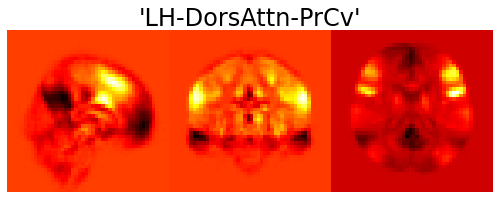

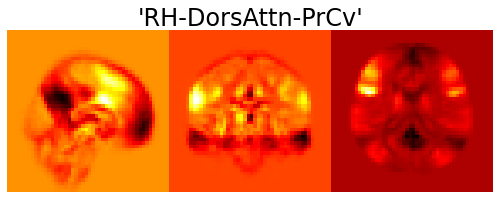

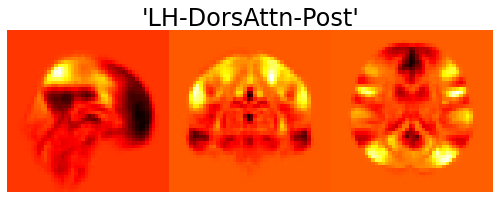

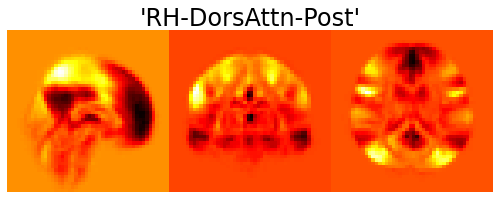

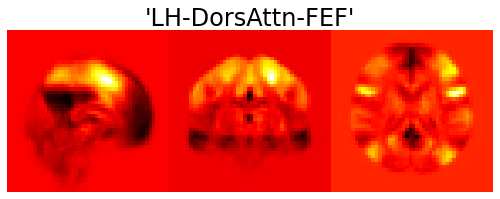

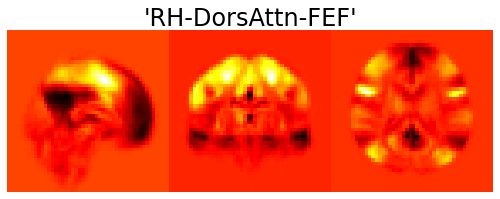

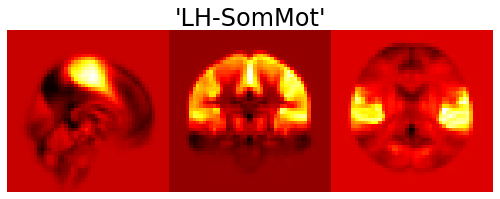

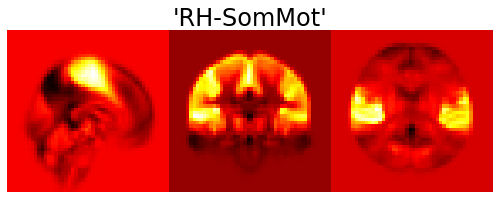

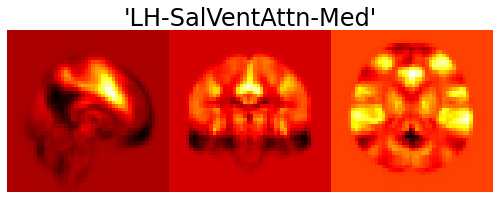

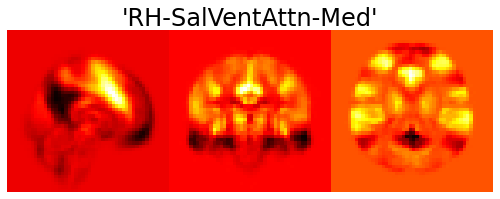

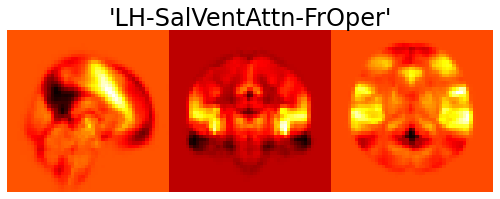

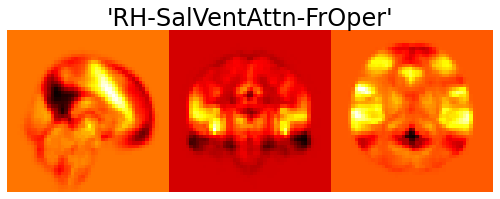

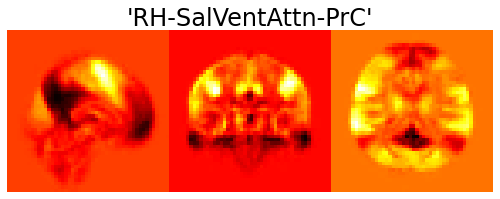

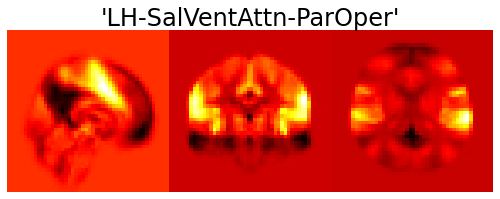

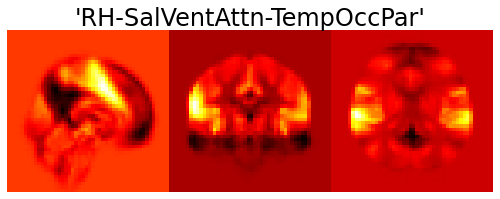

In [36]:
#rr = range(51)
#rr = np.argsort(im_avg.numpy().mean(axis=0).mean(axis=0).mean(axis=0))
rr = np.array(R['leaves'])
for r in rr:
    implot = ants.slice_image(im_avg,axis=3,idx=r)
    implot[np.isnan(implot.numpy())]=0
    implot.plot_ortho(overlay_alpha=.3,flat=True,cmap='hot',xyz_lines=False,orient_labels=False,title=rnames[r],overlay_cmap='gray')

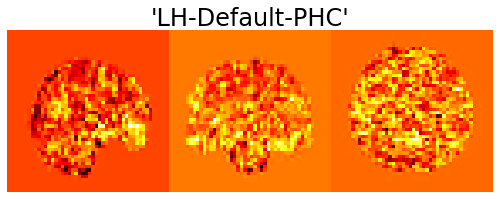

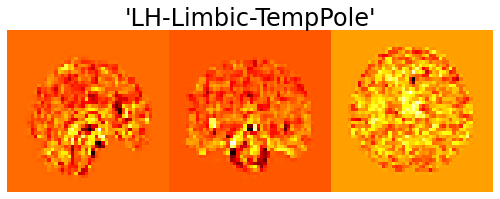

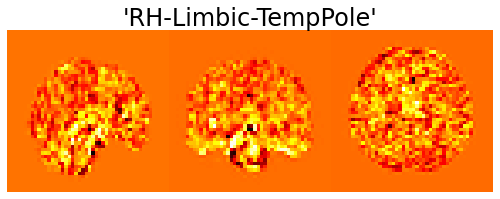

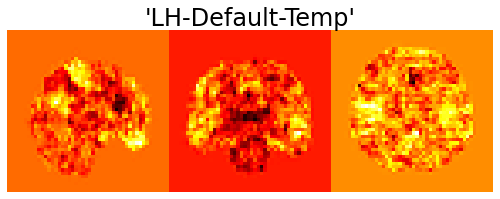

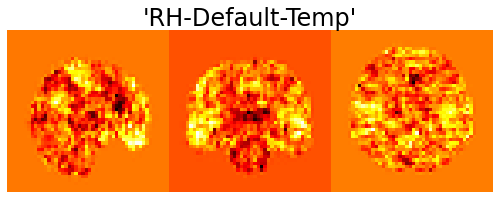

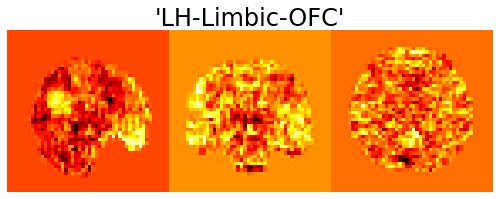

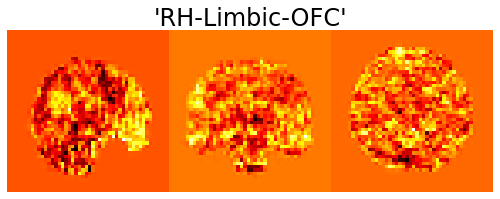

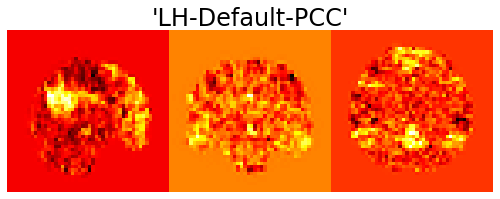

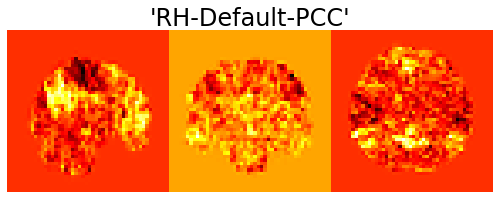

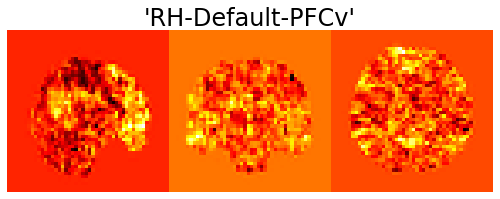

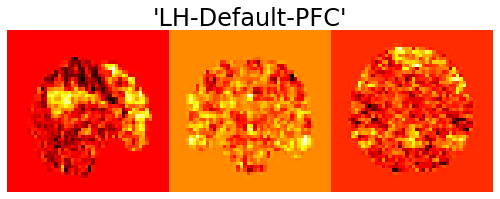

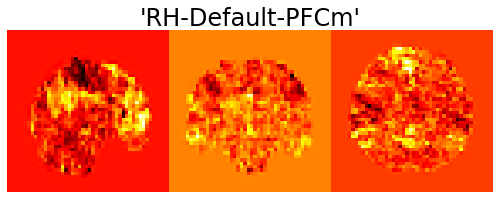

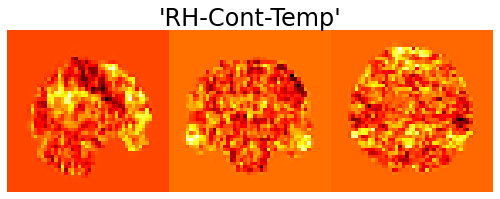

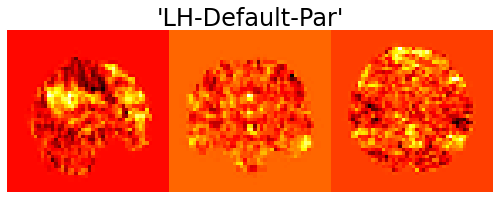

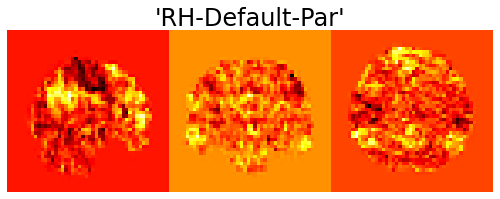

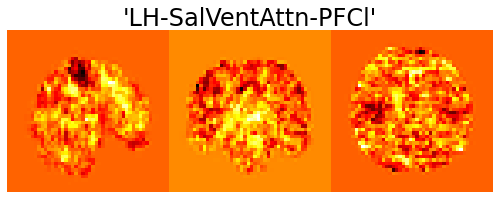

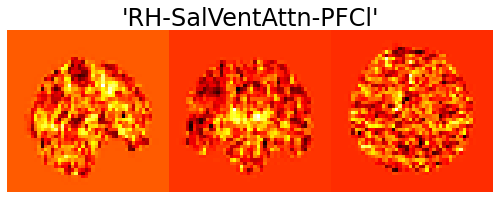

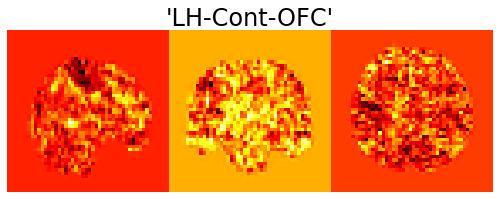

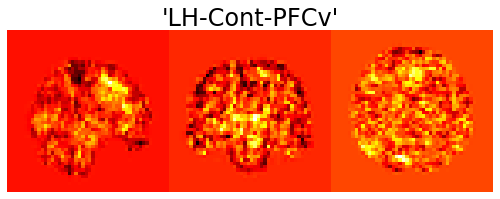

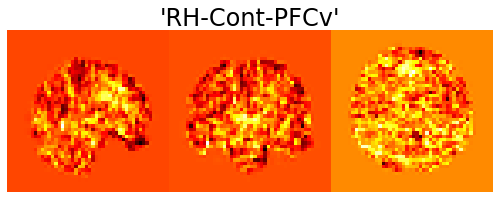

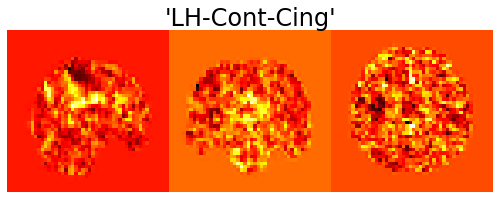

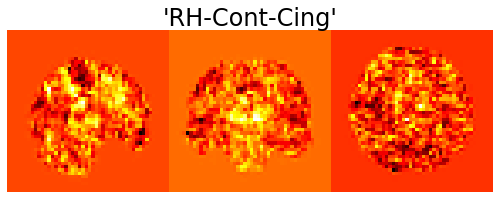

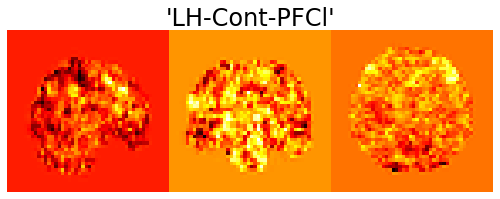

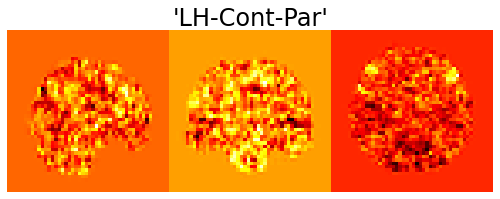

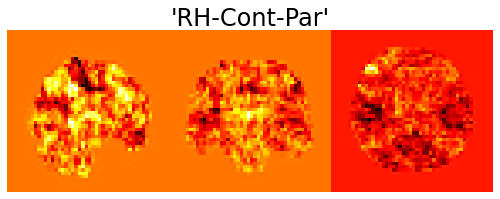

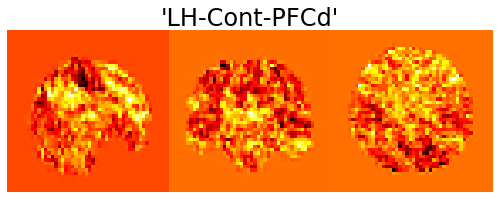

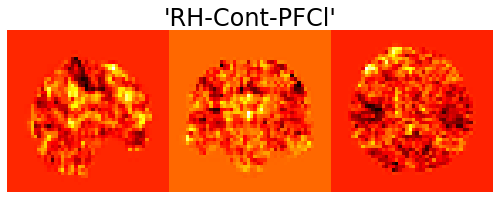

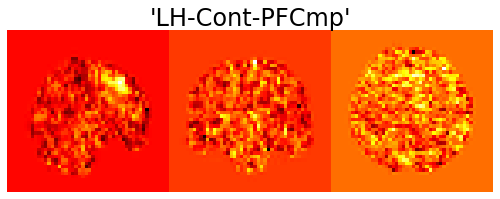

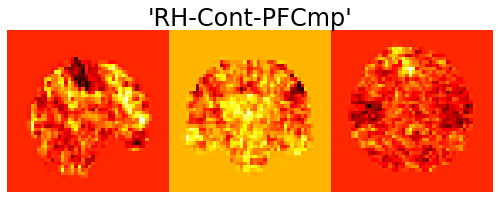

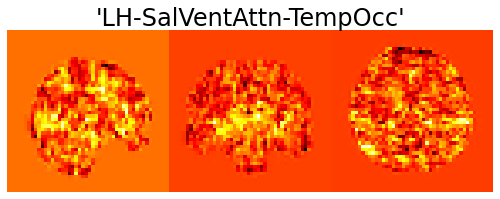

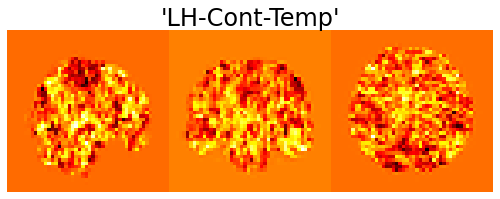

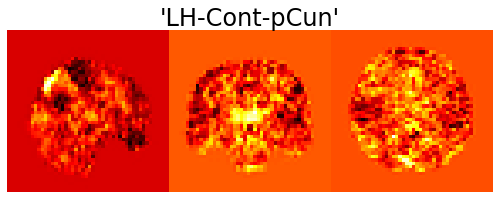

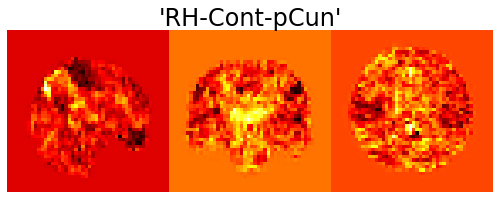

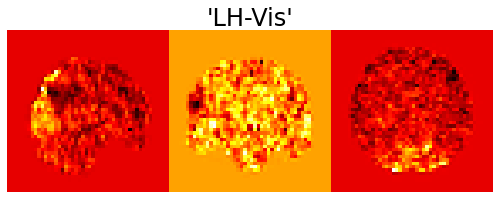

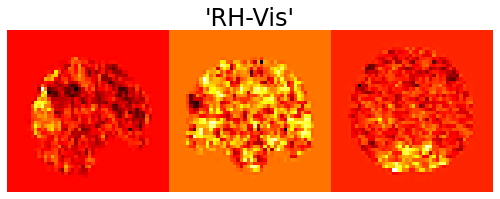

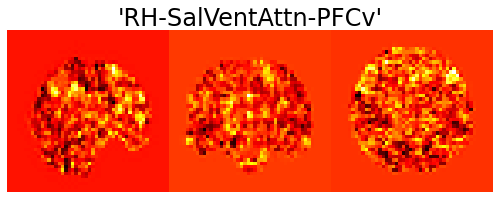

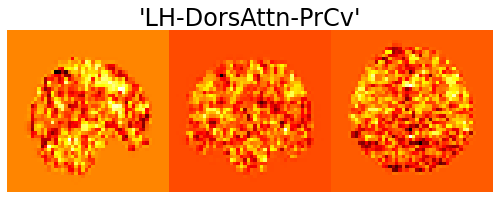

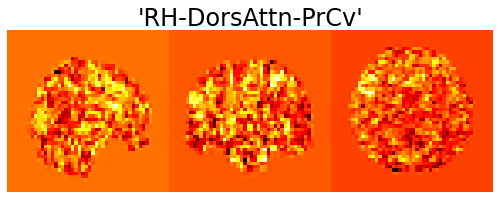

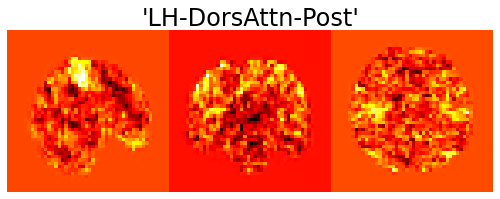

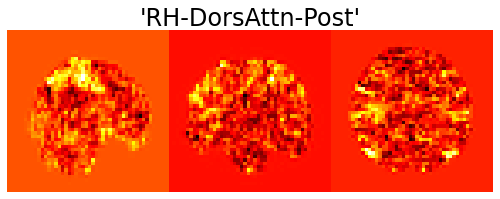

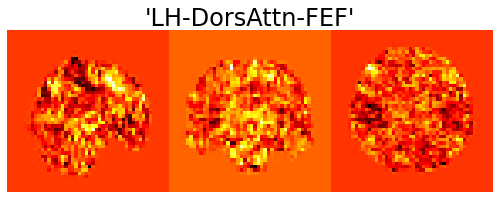

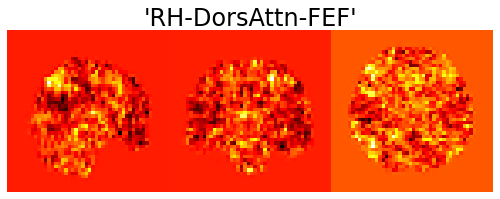

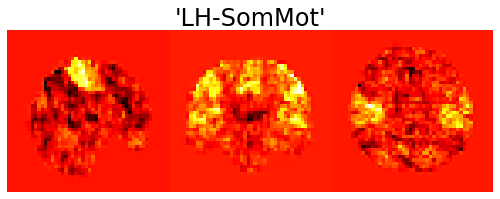

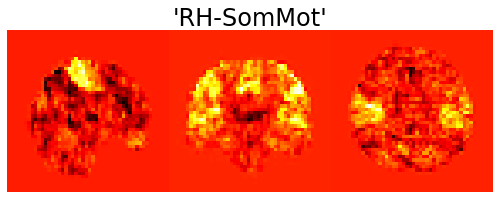

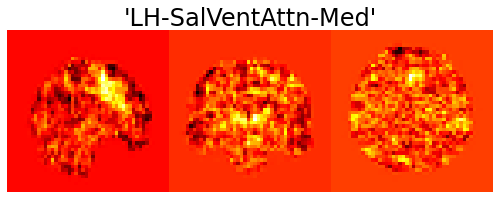

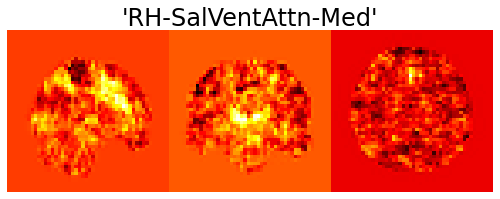

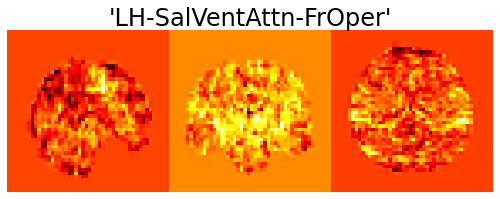

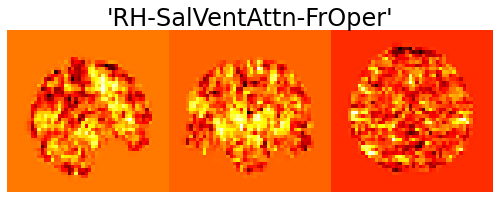

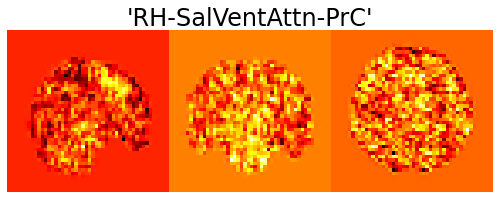

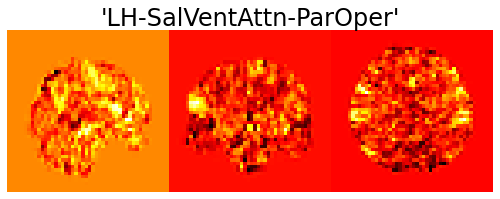

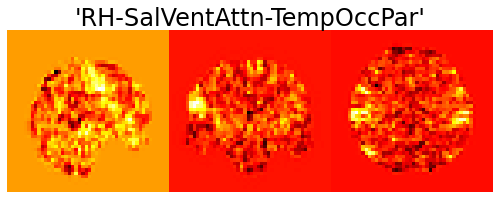

In [37]:
#rr = range(51)
#rr = np.argsort(im_avg.numpy().mean(axis=0).mean(axis=0).mean(axis=0))
rr = np.array(R['leaves'])
for r in rr:
    implot = ants.slice_image(im,axis=3,idx=r)
    implot[np.isnan(implot.numpy())]=0
    implot.plot_ortho(overlay_alpha=.3,flat=True,cmap='hot',xyz_lines=False,orient_labels=False,title=rnames[r],overlay_cmap='gray')

'../Assets/fc_mats_fc_mats_32smooth/'

In [77]:
indir = '../Assets/fc_maps_orig/'
ofdir = '../Assets/fc_maps_32smooth/'

mat_ofdir = ofdir.replace('fc_maps','fc_mats')


assert os.path.exists(indir), 'what'

if not os.path.exists(ofdir):
    os.mkdir(ofdir)

if not os.path.exists(mat_ofdir):
    os.mkdir(mat_ofdir)

    
infiles = [file for file in os.listdir(indir) if file.endswith(file)]
infiles.sort()    

for s in tqdm(range(len(infiles)),leave=True,position=0):    
    if not os.path.exists(os.path.join(ofdir,infiles[s])):
        im = ants.image_read(os.path.join(indir,infiles[s]))
        im = im.resample_image((32,32,32,51),use_voxels=True,interp_type=4)
        im = im.smooth_image(sigma=3,sigma_in_physical_coordinates=False,FWHM=True,max_kernel_width=32)
        im = ants.iMath_normalize(im)
        np.savez_compressed(os.path.join(mat_ofdir,infiles[s].replace('.nii','.npz')),data=im.numpy())

        im.to_filename(os.path.join(ofdir,infiles[s]))

100%|██████████| 1068/1068 [29:04<00:00,  1.63s/it]


In [ ]:
#im.slice_image(axis=3,idx=0).plot_ortho(flat=True)